# ERIKS Digital - Conversion Program Analysis
ERIKS is a major B2B supplier of industrial parts and machinery in the Netherlands. I work for ERIKS Digital, an internal branch of ERIKS, as a Junior Data Scientist. We primarily deal with the webshop, digital marketing and analytics.  

A conversion program was run at ED in 2019, to move customers who traditionally ordered offline to the webshop, primarily to save on costs involved in processing such offline orders. Customers underwent a conversion program, within which they were made an account on our webshop, and directed through an initial order.  

I was asked to use our database of orders data, and a list of customer IDs, to analyse how successful this program had been.  

Customers were divided up into three groups:  

'Converted' - offline customers who went through a conversion program, and made their first order online.  
'Still Online' - customers who were ordering online anyway, and were unaffected by the conversion program.  
'Still Offline' - customers who were ordering offline anyway, and were unaffected by the conversion program.  

The following questions have been investigated:  
a. How much has each group ordered over time?  
b. Which methods did each group use to order (offline, online, ePDF), and in what proportions?  
c. How did the percentage of online orders change over time for each group?  
d. How did the sales value change over time?  
e. How did the diversity of orders change over time?  
f. Did customers in different industries order in different proportions across the different order channels?  
g. How much of each group's orders were placed offline, but the product could have been ordered online (= 'Gen Pub')?  
h. Which industries are placing the most offline orders, which could have been placed online?  

# Setup

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

## Import Customer IDs.

In [2]:
df_conversion_cst = pd.read_csv(r"Conversion_CST.csv") # Place file in same folder as notebook 
#df_conversion_cst.CustomerId = df_conversion_cst.CustomerId.astype(str) 
conversion_cst_customer_ids = df_conversion_cst['CustomerId'].unique()
df_conversion_cst.head()

,Unnamed: 0,CustomerId,PurchaseOrderTypeDescription,Status,Converted,Klantnummer,CST
0,21,1005291,Offline,NaN,Still Offline,1005291,CST
1,24,1005303,Webshop,Webshop,Still Online,1005303,CST
2,26,1005305,Webshop,Webshop,Still Online,1005305,CST
3,36,1005314,Webshop,Webshop,Still Online,1005314,CST
4,38,1005315,Offline,NaN,Still Offline,1005315,CST


## Automate the writing of a SQL query, to extract data on the Customer IDs given.

In [3]:
sql_list = "("

for x in range(len(conversion_cst_customer_ids)):
    sql_list += "'" + str(conversion_cst_customer_ids[x]) + "'" + ", " 
    
sql_list = sql_list[:-2]
sql_list += ")"

script_after = "Select OriginalOrderNumber, OrderNumber, CustomerId, CustomerName, TurnoverClass, IndustryCode2Description, ArticleProdGroupNL, PurchaseOrderTypeDescription, SalesDocumentHeaderCreationDate, SalesValue, Quantity, MaterialGroup2Description FROM [weekly].[OrdersNLBE] Where SalesDocumentHeaderCreationDate >= '2018-12-05' and SalesDocumentHeaderCreationDate <= '2019-08-31' and CustomerId in %s" %sql_list

print (script_after) #Run this in SQL to update order data


Select OriginalOrderNumber, OrderNumber, CustomerId, CustomerName, TurnoverClass, IndustryCode2Description, ArticleProdGroupNL, PurchaseOrderTypeDescription, SalesDocumentHeaderCreationDate, SalesValue, Quantity, MaterialGroup2Description FROM [weekly].[OrdersNLBE] Where SalesDocumentHeaderCreationDate >= '2018-12-05' and SalesDocumentHeaderCreationDate <= '2019-08-31' and CustomerId in ('1005291', '1005303', '1005305', '1005314', '1005315', '1005340', '1005348', '1005353', '1005360', '1005408', '1005412', '1005430', '1005461', '1005468', '1005473', '1005475', '1005500', '1005504', '1005507', '1005509', '1005515', '1005522', '1005551', '1005561', '1005569', '1005592', '1005596', '1005642', '1005676', '1005677', '1005692', '1005732', '1005789', '1005793', '1005819', '1005834', '1005835', '1005844', '1005856', '1005862', '1005863', '1005874', '1005894', '1005937', '1005938', '1005948', '1005968', '1005985', '1006003', '1006005', '1006007', '1006020', '1006050', '1006059', '1006067', '100

## Import dataset saved from SQL query

In [4]:
df_orders = pd.read_csv(r"df_orders.csv") # Place file in same folder as notebook 
df_orders_anon = df_orders.drop(['CustomerName'], axis=1)
df_orders_anon.head()

,OriginalOrderNumber,OrderNumber,CustomerId,TurnoverClass,IndustryCode2Description,ArticleProdGroupNL,PurchaseOrderTypeDescription,SalesDocumentHeaderCreationDate,SalesValue,Quantity,MaterialGroup2Description
0,350429374/10/1,350429374,1005569,NaN,Chemical,13,Offline,2019-07-29,9.50,10.0,General published
1,350429374/20/1,350429374,1005569,NaN,Chemical,13,Offline,2019-07-29,7.40,10.0,General published
2,350429374/30/1,350429374,1005569,NaN,Chemical,13,Offline,2019-07-29,32.40,10.0,General published
3,350429374/40/1,350429374,1005569,NaN,Chemical,A2,Offline,2019-07-29,338.84,1.0,Customer-specific published
4,350429374/50/1,350429374,1005569,NaN,Chemical,H3,Offline,2019-07-29,186.00,300.0,Customer-specific published


## Sanity check

In [5]:
Column_name = 'CustomerId'
print (f' Number of unique customer IDs in provided dataset = {df_conversion_cst[Column_name].nunique()}')
print (f' Number of unique customer IDs in orders dataframe = {df_orders[Column_name].nunique()}')

 Number of unique customer IDs in provided dataset = 2707
 Number of unique customer IDs in orders dataframe = 2682


So of the 2707 customer IDs we were provided, 2682 placed orders in the designated timeframe (found in SQL query above)

## Data cleaning

In [6]:
df_orders.TurnoverClass = df_orders.TurnoverClass.astype(str)
#df_orders.CustomerId = df_orders.CustomerId.astype(str)
df_orders['SalesDocumentHeaderCreationDate'] = pd.to_datetime(df_orders['SalesDocumentHeaderCreationDate'])


# How much has each group ordered over time?  

## Split orders dataframe into three different dataframes, for customers labelled "Converted", "Still Online" and "Still Offline"

In [7]:
converted_customerIDs_list = df_conversion_cst[df_conversion_cst['Converted'] == 'Converted']['CustomerId'].unique().tolist()
converted_customer_orders_df = df_orders[df_orders['CustomerId'].isin(converted_customerIDs_list)].reset_index(drop=True)
print (f'len(converted_customer_orders_df) = {len(converted_customer_orders_df)}')


len(converted_customer_orders_df) = 42743


In [8]:
still_online_customerIDs_list = df_conversion_cst[df_conversion_cst['Converted'] == 'Still Online']['CustomerId'].unique().tolist()
still_online_customer_orders_df = df_orders[df_orders['CustomerId'].isin(still_online_customerIDs_list)].reset_index(drop=True)
print (f'len(still_online_customer_orders_df) = {len(still_online_customer_orders_df)}')


len(still_online_customer_orders_df) = 35180


In [9]:
still_offline_customerIDs_list = df_conversion_cst[df_conversion_cst['Converted'] == 'Still Offline']['CustomerId'].unique()
still_offline_customer_orders_df = df_orders[df_orders['CustomerId'].isin(still_offline_customerIDs_list)].reset_index(drop=True)
print (f'len(still_offline_customer_orders_df) = {len(still_offline_customer_orders_df)}')


len(still_offline_customer_orders_df) = 94579


## Calculate the number of orders per month, for each group 
Note: Orderlines = number of unique items, on each order

### Converted Customers

Text(0.5, 1.0, 'Number of Orderlines from Converted Customers per Month')

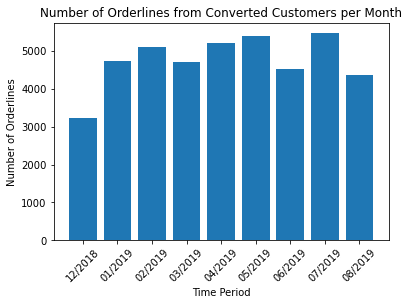

In [10]:
converted_customer_orders_df_grouped = converted_customer_orders_df.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins = []
list_of_group_sizes = []
for name, group in converted_customer_orders_df_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes.append(len(group.index))

plt.bar(list_of_date_bins, list_of_group_sizes)
plt.xticks(rotation = 45)
plt.xlabel("Time Period")
plt.ylabel("Number of Orderlines")
plt.title("Number of Orderlines from Converted Customers per Month")

### Still Offline Customers

Text(0.5, 1.0, "Number of Orderlines from 'Still Offline' Customers per Month")

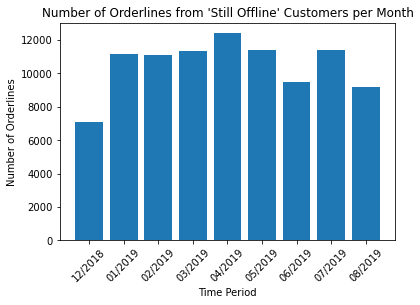

In [11]:
still_offline_customer_orders_df_grouped = still_offline_customer_orders_df.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins = []
list_of_group_sizes = []
for name, group in still_offline_customer_orders_df_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes.append(len(group.index))

plt.bar(list_of_date_bins, list_of_group_sizes)
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.ylabel("Number of Orderlines")
plt.title("Number of Orderlines from 'Still Offline' Customers per Month")

### Still Online Orders

Text(0.5, 1.0, "Number of Orderlines from 'Still Online' Customers per Month")

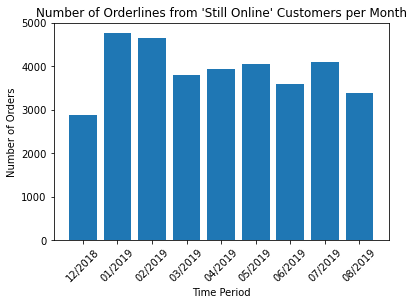

In [12]:
still_online_customer_orders_df_grouped = still_online_customer_orders_df.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins = []
list_of_group_sizes = []
for name, group in still_online_customer_orders_df_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes.append(len(group.index))

plt.bar(list_of_date_bins, list_of_group_sizes)
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.ylabel("Number of Orders")
plt.title("Number of Orderlines from 'Still Online' Customers per Month")

# Which methods did each group use to order (offline, online, ePDF), and in what proportions?  


## Number of Orderlines over time - Converted

Text(0.5, 1.0, "Orderlines Breakdown for 'Converted' Customers")

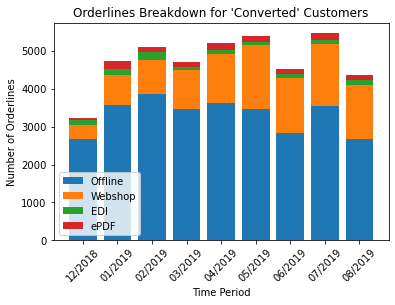

In [13]:
converted_offline_df = converted_customer_orders_df[converted_customer_orders_df['PurchaseOrderTypeDescription'] == 'Offline'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
converted_webshop_df = converted_customer_orders_df[converted_customer_orders_df['PurchaseOrderTypeDescription'] == 'Webshop'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
converted_edi_df = converted_customer_orders_df[converted_customer_orders_df['PurchaseOrderTypeDescription'] == 'EDI'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
converted_epdf_df = converted_customer_orders_df[converted_customer_orders_df['PurchaseOrderTypeDescription'] == 'ePDF'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins_offline = []
list_of_group_sizes_offline = []
for name, group in converted_offline_df:
    list_of_date_bins_offline.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_offline.append(group.shape[0])

list_of_date_bins_webshop = []
list_of_group_sizes_webshop = []
for name, group in converted_webshop_df:
    list_of_date_bins_webshop.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_webshop.append(group.shape[0])
    
list_of_date_bins_edi = []
list_of_group_sizes_edi = []
for name, group in converted_edi_df:
    list_of_date_bins_edi.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_edi.append(group.shape[0])
    
list_of_date_bins_epdf = []
list_of_group_sizes_epdf = []
for name, group in converted_epdf_df:
    list_of_date_bins_epdf.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_epdf.append(group.shape[0])
    
offline_plus_webshop = [x + y for x, y in zip(list_of_group_sizes_offline, list_of_group_sizes_webshop)]
offline_plus_webshop_plus_edi = [x + y for x, y in zip(offline_plus_webshop, list_of_group_sizes_edi)]

plt.bar(list_of_date_bins_offline, list_of_group_sizes_offline, label = 'Offline')
plt.bar(list_of_date_bins_webshop, list_of_group_sizes_webshop, bottom = list_of_group_sizes_offline, label = 'Webshop')
plt.bar(list_of_date_bins_edi, list_of_group_sizes_edi, bottom = offline_plus_webshop, label = 'EDI')
plt.bar(list_of_date_bins_epdf, list_of_group_sizes_epdf, bottom = offline_plus_webshop_plus_edi, label = 'ePDF')

plt.legend()
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.ylabel("Number of Orderlines")
plt.title("Orderlines Breakdown for 'Converted' Customers")


Note the increase in size of the orange segments (Webshop orders) over time for converted customers. They look to be making more of their orders online over time. 

Also: This code to produce a stacked bar chart could probably be vastly simplified with Plotly

## Number of Orderlines over time - Offline

Text(0.5, 1.0, "Orderlines Breakdown for 'Still Offline' Customers")

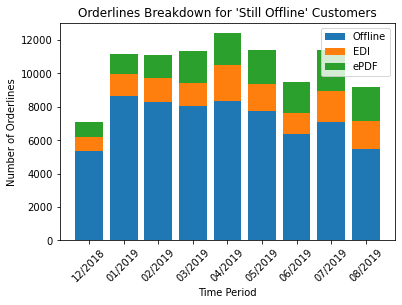

In [14]:
still_offline_offline_df = still_offline_customer_orders_df[still_offline_customer_orders_df['PurchaseOrderTypeDescription'] == 'Offline'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
still_offline_webshop_df = still_offline_customer_orders_df[still_offline_customer_orders_df['PurchaseOrderTypeDescription'] == 'Webshop'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
still_offline_edi_df = still_offline_customer_orders_df[still_offline_customer_orders_df['PurchaseOrderTypeDescription'] == 'EDI'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
still_offline_epdf_df = still_offline_customer_orders_df[still_offline_customer_orders_df['PurchaseOrderTypeDescription'] == 'ePDF'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins_offline = []
list_of_group_sizes_offline = []
for name, group in still_offline_offline_df:
    list_of_date_bins_offline.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_offline.append(group.shape[0])

list_of_date_bins_webshop = []
list_of_group_sizes_webshop = []
for name, group in still_offline_webshop_df:
    list_of_date_bins_webshop.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_webshop.append(group.shape[0])
    
list_of_date_bins_edi = []
list_of_group_sizes_edi = []
for name, group in still_offline_edi_df:
    list_of_date_bins_edi.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_edi.append(group.shape[0])
    
list_of_date_bins_epdf = []
list_of_group_sizes_epdf = []
for name, group in still_offline_epdf_df:
    list_of_date_bins_epdf.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_epdf.append(group.shape[0])
    
offline_plus_webshop = [x + y for x, y in zip(list_of_group_sizes_offline, list_of_group_sizes_webshop)]
offline_plus_webshop_plus_edi = [x + y for x, y in zip(offline_plus_webshop, list_of_group_sizes_edi)]
offline_plus_edi = [x + y for x, y in zip(list_of_group_sizes_offline, list_of_group_sizes_edi)]

plt.bar(list_of_date_bins_offline, list_of_group_sizes_offline, label = 'Offline')
plt.bar(list_of_date_bins_edi, list_of_group_sizes_edi, bottom = list_of_group_sizes_offline, label = 'EDI')
plt.bar(list_of_date_bins_epdf, list_of_group_sizes_epdf, bottom = offline_plus_edi, label = 'ePDF')

plt.legend()
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.ylabel("Number of Orderlines")
plt.title("Orderlines Breakdown for 'Still Offline' Customers")


## Number of Orderlines over time - Online

Text(0.5, 1.0, "Orderlines Breakdown for 'Still Online' Customers")

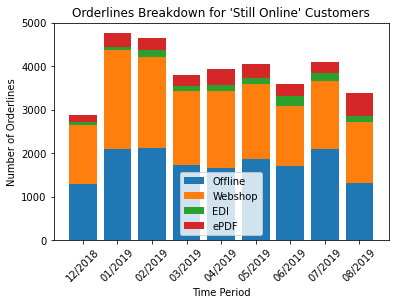

In [15]:
still_online_offline_df = still_online_customer_orders_df[still_online_customer_orders_df['PurchaseOrderTypeDescription'] == 'Offline'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
still_online_webshop_df = still_online_customer_orders_df[still_online_customer_orders_df['PurchaseOrderTypeDescription'] == 'Webshop'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
still_online_edi_df = still_online_customer_orders_df[still_online_customer_orders_df['PurchaseOrderTypeDescription'] == 'EDI'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
still_online_epdf_df = still_online_customer_orders_df[still_online_customer_orders_df['PurchaseOrderTypeDescription'] == 'ePDF'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins_offline = []
list_of_group_sizes_offline = []
for name, group in still_online_offline_df:
    list_of_date_bins_offline.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_offline.append(group.shape[0])

list_of_date_bins_webshop = []
list_of_group_sizes_webshop = []
for name, group in still_online_webshop_df:
    list_of_date_bins_webshop.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_webshop.append(group.shape[0])
    
list_of_date_bins_edi = []
list_of_group_sizes_edi = []
for name, group in still_online_edi_df:
    list_of_date_bins_edi.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_edi.append(group.shape[0])
    
list_of_date_bins_epdf = []
list_of_group_sizes_epdf = []
for name, group in still_online_epdf_df:
    list_of_date_bins_epdf.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_epdf.append(group.shape[0])
    
offline_plus_webshop = [x + y for x, y in zip(list_of_group_sizes_offline, list_of_group_sizes_webshop)]
offline_plus_webshop_plus_edi = [x + y for x, y in zip(offline_plus_webshop, list_of_group_sizes_edi)]
offline_plus_edi = [x + y for x, y in zip(list_of_group_sizes_offline, list_of_group_sizes_edi)]

plt.bar(list_of_date_bins_offline, list_of_group_sizes_offline, label = 'Offline')
plt.bar(list_of_date_bins_webshop, list_of_group_sizes_webshop, bottom = list_of_group_sizes_offline, label = 'Webshop')
plt.bar(list_of_date_bins_edi, list_of_group_sizes_edi, bottom = offline_plus_webshop, label = 'EDI')
plt.bar(list_of_date_bins_epdf, list_of_group_sizes_epdf, bottom = offline_plus_webshop_plus_edi, label = 'ePDF')

plt.legend()
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.ylabel("Number of Orderlines")
plt.title("Orderlines Breakdown for 'Still Online' Customers")

Customers who were already ordering online seem to have a faily constant percentage of online orders. This should be the benchmark that the converted customers online orders percentage should be compared against. 

# How did the percentage of online orders change over time for each group?  

## Converted Customers

Text(0, 0.5, 'Percentage')

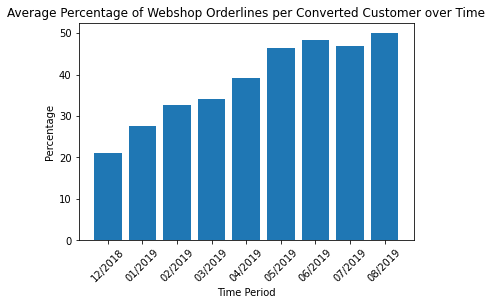

In [16]:
converted_customer_orders_df_grouped = converted_customer_orders_df.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
list_of_date_bins = []
list_of_average_online_orders = []
for name, group in converted_customer_orders_df_grouped:
    customer_level_group_by = group.groupby("CustomerId")
    list_of_customer_averages_in_one_month = []
    for customer, customer_dataframe in customer_level_group_by:  
        list_of_customer_averages_in_one_month.append( len(customer_dataframe[customer_dataframe['PurchaseOrderTypeDescription'] == 'Webshop']) / len(customer_dataframe))
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    list_of_average_online_orders.append(100*np.mean(list_of_customer_averages_in_one_month))
plt.bar(list_of_date_bins, list_of_average_online_orders)
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.title("Average Percentage of Webshop Orderlines per Converted Customer over Time")
plt.ylabel("Percentage")

Interesting! The percentage of online/webshop orders for converted seems to have plateaud around 50% on average for each converted customer. What is the corresponding value for 'Still Online' customers?

## 'Still Online' Customers

Text(0, 0.5, 'Percentage')

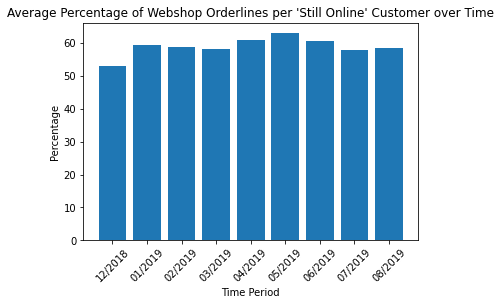

In [17]:
still_online_orders_df_grouped = still_online_customer_orders_df.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
list_of_date_bins = []
list_of_average_online_orders = []
for name, group in still_online_customer_orders_df_grouped:
    customer_level_group_by = group.groupby("CustomerId")
    list_of_customer_averages_in_one_month = []
    for customer, customer_dataframe in customer_level_group_by:  
        list_of_customer_averages_in_one_month.append( len(customer_dataframe[customer_dataframe['PurchaseOrderTypeDescription'] == 'Webshop']) / len(customer_dataframe))
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    list_of_average_online_orders.append(100*np.mean(list_of_customer_averages_in_one_month))
plt.bar(list_of_date_bins, list_of_average_online_orders)
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.title("Average Percentage of Webshop Orderlines per 'Still Online' Customer over Time")
plt.ylabel("Percentage")

Okay, so the average seems to be around 55% for 'Still Online' customers, which means that the converted customers are quite close to this benchmark value in ordering behaviour, with their average being around 50%!

# How did the value of total sales change over time?  

Text(0.5, 1.0, 'Sales Value for Converted Customers over Time')

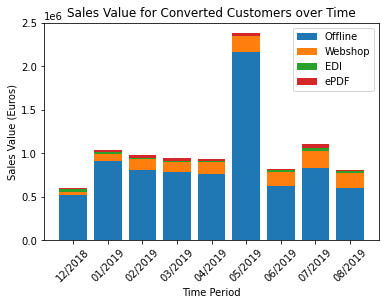

In [18]:
converted_offline_df = converted_customer_orders_df[converted_customer_orders_df['PurchaseOrderTypeDescription'] == 'Offline'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
converted_webshop_df = converted_customer_orders_df[converted_customer_orders_df['PurchaseOrderTypeDescription'] == 'Webshop'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
converted_edi_df = converted_customer_orders_df[converted_customer_orders_df['PurchaseOrderTypeDescription'] == 'EDI'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
converted_epdf_df = converted_customer_orders_df[converted_customer_orders_df['PurchaseOrderTypeDescription'] == 'ePDF'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins_offline = []
list_of_sales_values_offline = []
for name, group in converted_offline_df:
    list_of_date_bins_offline.append(name.date().strftime('%m/%Y'))
    list_of_sales_values_offline.append(group.SalesValue.sum())

list_of_date_bins_webshop = []
list_of_sales_values_webshop = []
for name, group in converted_webshop_df:
    list_of_date_bins_webshop.append(name.date().strftime('%m/%Y'))
    list_of_sales_values_webshop.append(group.SalesValue.sum())
    
list_of_date_bins_edi = []
list_of_sales_values_edi = []
for name, group in converted_edi_df:
    list_of_date_bins_edi.append(name.date().strftime('%m/%Y'))
    list_of_sales_values_edi.append(group.SalesValue.sum())
    
list_of_date_bins_epdf = []
list_of_sales_values_epdf = []
for name, group in converted_epdf_df:
    list_of_date_bins_epdf.append(name.date().strftime('%m/%Y'))
    list_of_sales_values_epdf.append(group.SalesValue.sum())
    
offline_plus_webshop = [x + y for x, y in zip(list_of_sales_values_offline, list_of_sales_values_webshop)]
offline_plus_webshop_plus_edi = [x + y for x, y in zip(offline_plus_webshop, list_of_sales_values_edi)]

plt.bar(list_of_date_bins_offline, list_of_sales_values_offline, label = 'Offline')
plt.bar(list_of_date_bins_webshop, list_of_sales_values_webshop, bottom = list_of_sales_values_offline, label = 'Webshop')
plt.bar(list_of_date_bins_edi, list_of_sales_values_edi, bottom = offline_plus_webshop, label = 'EDI')
plt.bar(list_of_date_bins_epdf, list_of_sales_values_epdf, bottom = offline_plus_webshop_plus_edi, label = 'ePDF')

plt.legend()
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.ylabel("Sales Value (Euros)")
plt.title("Sales Value for Converted Customers over Time")


# How did the diversity of orders change over time?  
Diversity can be measured by the number of 'product groups', a classification of product types, ordered over time. 

## Converted


Text(0, 0.5, 'Number of Product Groups')

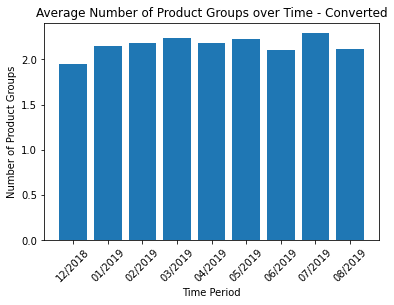

In [19]:
converted_customer_orders_df_grouped = converted_customer_orders_df.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
list_of_date_bins = []
list_of_average_product_groups = []
for name, group in converted_customer_orders_df_grouped:
    customer_level_group_by = group.groupby("CustomerId")
    list_of_customer_product_group_numbers = []
    for customer, customer_dataframe in customer_level_group_by:  
        list_of_customer_product_group_numbers.append(customer_dataframe['ArticleProdGroupNL'].nunique())
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    list_of_average_product_groups.append(np.mean(list_of_customer_product_group_numbers))
plt.bar(list_of_date_bins, list_of_average_product_groups)
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.title("Average Number of Product Groups over Time - Converted")
plt.ylabel("Number of Product Groups")



## Still Offline


Text(0, 0.5, 'Number of Product Groups')

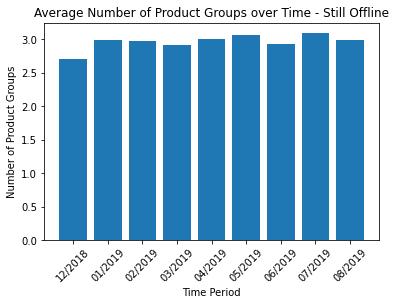

In [20]:
still_offline_customer_orders_df_grouped = still_offline_customer_orders_df.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
list_of_date_bins = []
list_of_average_product_groups = []
for name, group in still_offline_customer_orders_df_grouped:
    customer_level_group_by = group.groupby("CustomerId")
    list_of_customer_product_group_numbers = []
    for customer, customer_dataframe in customer_level_group_by:  
        list_of_customer_product_group_numbers.append(customer_dataframe['ArticleProdGroupNL'].nunique())
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    list_of_average_product_groups.append(np.mean(list_of_customer_product_group_numbers))
plt.bar(list_of_date_bins, list_of_average_product_groups)
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.title("Average Number of Product Groups over Time - Still Offline")
plt.ylabel("Number of Product Groups")

## Still Online


Text(0, 0.5, 'Number of Product Groups')

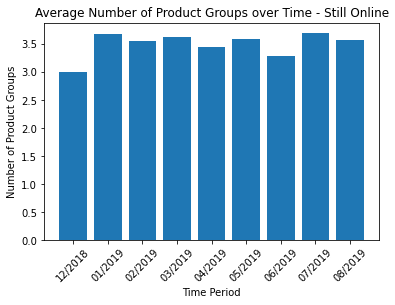

In [21]:
still_online_customer_orders_df_grouped = still_online_customer_orders_df.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
list_of_date_bins = []
list_of_average_product_groups = []
for name, group in still_online_customer_orders_df_grouped:
    customer_level_group_by = group.groupby("CustomerId")
    list_of_customer_product_group_numbers = []
    for customer, customer_dataframe in customer_level_group_by:  
        list_of_customer_product_group_numbers.append(customer_dataframe['ArticleProdGroupNL'].nunique())
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    list_of_average_product_groups.append(np.mean(list_of_customer_product_group_numbers))
plt.bar(list_of_date_bins, list_of_average_product_groups)
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.title("Average Number of Product Groups over Time - Still Online")
plt.ylabel("Number of Product Groups")

It seems that converted customers are consistently ordering a narrower range of products. Why could this be? Perhaps customers already online exhibit more 'window shopper behaviour', ordering things from a wider range, while converted customers know very clearly what they need? The average also stays fairly constant over time for converted customers, so perhaps they don't tend towards the behaviour of 'still online' customers as they did with their webshop order percentage? 

## Remove monthly binning

Text(0.5, 1.0, 'Product Group Diversity across Customer Types')

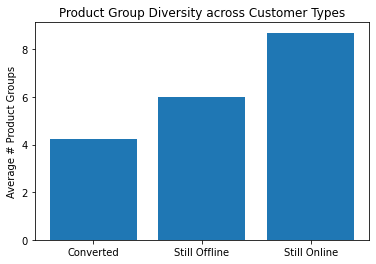

In [22]:
list_of_customer_category_bins = []
list_of_average_product_groups = []

converted_customer_orders_df_group_by = converted_customer_orders_df.groupby("CustomerId")
still_offline_customer_orders_df_group_by = still_offline_customer_orders_df.groupby("CustomerId")
still_online_customer_orders_df_group_by = still_online_customer_orders_df.groupby("CustomerId")

list_of_customer_product_group_numbers_converted = []
for customer, customer_dataframe in converted_customer_orders_df_group_by:  
    list_of_customer_product_group_numbers_converted.append(customer_dataframe['ArticleProdGroupNL'].nunique())
    
list_of_customer_product_group_numbers_still_offline = []
for customer, customer_dataframe in still_offline_customer_orders_df_group_by:  
    list_of_customer_product_group_numbers_still_offline.append(customer_dataframe['ArticleProdGroupNL'].nunique())
    
list_of_customer_product_group_numbers_still_online = []
for customer, customer_dataframe in still_online_customer_orders_df_group_by:  
    list_of_customer_product_group_numbers_still_online.append(customer_dataframe['ArticleProdGroupNL'].nunique())
    
list_of_customer_category_bins.append("Converted")
list_of_customer_category_bins.append("Still Offline")
list_of_customer_category_bins.append("Still Online")

list_of_average_product_groups.append(np.mean(list_of_customer_product_group_numbers_converted))
list_of_average_product_groups.append(np.mean(list_of_customer_product_group_numbers_still_offline))
list_of_average_product_groups.append(np.mean(list_of_customer_product_group_numbers_still_online))

plt.bar(list_of_customer_category_bins, list_of_average_product_groups)
plt.ylabel("Average # Product Groups")
plt.title("Product Group Diversity across Customer Types")


# Did customers in different industries order in different proportions across the different order channels?  

## Converted - number of orderlines by industry

Text(0.5, 1.0, 'Number of Webshop Orderlines - Converted Customers')

<Figure size 432x288 with 0 Axes>

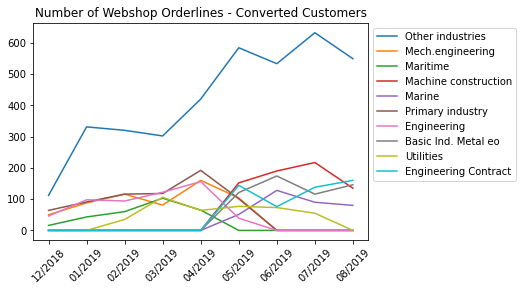

In [23]:
converted_customer_orders_df_grouped = converted_customer_orders_df[converted_customer_orders_df['PurchaseOrderTypeDescription'] == 'Webshop'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
list_of_industries = converted_customer_orders_df.IndustryCode2Description.value_counts().nlargest(10).index.tolist()
list_of_date_bins = []

for name, group in converted_customer_orders_df_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    
df = pd.DataFrame(0, columns = list_of_industries, index = list_of_date_bins) 

for name, group in converted_customer_orders_df_grouped:    
    months_industry_df = group.groupby(["IndustryCode2Description"]).count()["CustomerId"].reset_index(name='count').nlargest(10, 'count')
    for i in list_of_industries:
        list_of_active_industries_in_month = months_industry_df['IndustryCode2Description'].unique()
        if i in list_of_active_industries_in_month:            
            df.loc[name.date().strftime('%m/%Y')].at[i] = months_industry_df.loc[months_industry_df['IndustryCode2Description'] == i, 'count'].iloc[0]

plt.figure()
ax = df.plot(label = 'Converted')
plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.title('Number of Webshop Orderlines - Converted Customers')


## Converted - percentage of webshop orderlines by industry

Text(0.5, 1.0, 'Percentage Webshop Orders by Industry for Converted')

<Figure size 432x288 with 0 Axes>

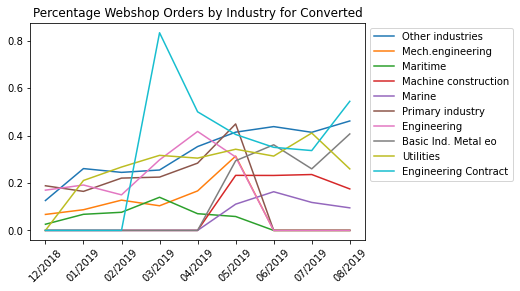

In [24]:
converted_customer_orders_df_grouped = converted_customer_orders_df.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
list_of_industries = converted_customer_orders_df.IndustryCode2Description.value_counts().nlargest(10).index.tolist()
list_of_date_bins = []

for name, group in converted_customer_orders_df_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    
df_converted = pd.DataFrame(0.0, columns = list_of_industries, index = list_of_date_bins) 

for name, group in converted_customer_orders_df_grouped:   
    only_webshop_for_scaling_df = group[group['PurchaseOrderTypeDescription'] == 'Webshop']
    only_webshop_for_scaling_df = only_webshop_for_scaling_df[only_webshop_for_scaling_df["IndustryCode2Description"].isin(list_of_industries)]    
    months_industry_df = group.groupby(["IndustryCode2Description"]).count()["CustomerId"].reset_index(name='count')
    only_webshop_for_scaling_df = only_webshop_for_scaling_df.groupby(["IndustryCode2Description"]).count()["CustomerId"].reset_index(name='count')

    for i in list_of_industries:
        list_of_active_industries_in_month = months_industry_df['IndustryCode2Description'].unique()
        list_of_active_webshop_industries_in_month = only_webshop_for_scaling_df['IndustryCode2Description'].unique()
        if i in list_of_active_industries_in_month and i in list_of_active_webshop_industries_in_month:            
            df_converted.loc[name.date().strftime('%m/%Y')].at[i] = (1.0*only_webshop_for_scaling_df.loc[only_webshop_for_scaling_df['IndustryCode2Description'] == i, 'count'].iloc[0]) / (1.0*months_industry_df.loc[months_industry_df['IndustryCode2Description'] == i, 'count'].iloc[0]) 

plt.figure()
ax = df_converted.plot(label = 'Converted')
plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.title("Percentage Webshop Orders by Industry for Converted")


# How much of each group's orders were placed offline, but the product could have been ordered online (= 'Gen Pub')?  

## Converted customers

Text(0.5, 1.0, 'Potential Online Orders Analysis for Converted Customers')

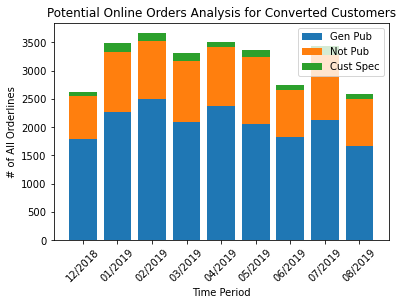

In [25]:
converted_customer_orders_df = df_orders[df_orders['CustomerId'].isin(converted_customerIDs_list)].reset_index(drop=True)
converted_offline_df = converted_customer_orders_df[converted_customer_orders_df['PurchaseOrderTypeDescription'] == 'Offline']
converted_genpub_df = converted_offline_df[converted_offline_df['MaterialGroup2Description'] == 'General published'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
converted_notpub_df = converted_offline_df[converted_offline_df['MaterialGroup2Description'] == 'Do not publish'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
converted_custspec_df = converted_offline_df[converted_offline_df['MaterialGroup2Description'] == 'Customer-specific published'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins_genpub = []
list_of_group_sizes_genpub = []
for name, group in converted_genpub_df:
    list_of_date_bins_genpub.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_genpub.append(group.shape[0])

list_of_date_bins_notpub = []
list_of_group_sizes_notpub = []
for name, group in converted_notpub_df:
    list_of_date_bins_notpub.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_notpub.append(group.shape[0])
    
list_of_date_bins_custspec = []
list_of_group_sizes_custspec = []
for name, group in converted_custspec_df:
    list_of_date_bins_custspec.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_custspec.append(group.shape[0])

list_of_group_sizes_genpub_normed = [x*100 / (float(len(df_orders))) for x in list_of_group_sizes_genpub]
list_of_group_sizes_notpub_normed = [x*100 / float(len(df_orders)) for x in list_of_group_sizes_notpub]
list_of_group_sizes_custspec_normed = [x*100 / float(len(df_orders)) for x in list_of_group_sizes_custspec]

genpub_plus_notpub = [x + y for x, y in zip(list_of_group_sizes_genpub, list_of_group_sizes_notpub)]
genpub_plus_notpub_normed = [x + y for x, y in zip(list_of_group_sizes_genpub_normed, list_of_group_sizes_notpub_normed)]

plt.bar(list_of_date_bins_genpub, list_of_group_sizes_genpub, label = 'Gen Pub')
plt.bar(list_of_date_bins_notpub, list_of_group_sizes_notpub, bottom = list_of_group_sizes_genpub, label = 'Not Pub')
plt.bar(list_of_date_bins_custspec, list_of_group_sizes_custspec, bottom = genpub_plus_notpub, label = 'Cust Spec')

plt.legend()
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.ylabel("# of All Orderlines")
plt.title("Potential Online Orders Analysis for Converted Customers")

## Still Offline customers

General published                        56429
Do not publish                           29621
Customer-specific published               4924
Drop general publ. query, check PIM         55
Negative PIM gen.publ., BU correction       31
General publ. query, check PIM              19
Cust.specif.publ. query, check PIM          17
Neg. PIM cust-sp.publ., BU correction        4
Name: MaterialGroup2Description, dtype: int64
[3241, 5255, 4774, 4511, 5040, 4395, 3802, 4177, 3160]
[1768, 2808, 2803, 2941, 2734, 2696, 2049, 2327, 1874]
[212, 339, 294, 342, 371, 344, 318, 319, 213]


Text(0.5, 1.0, 'Potential Online Orders Analysis for Still Offline Customers')

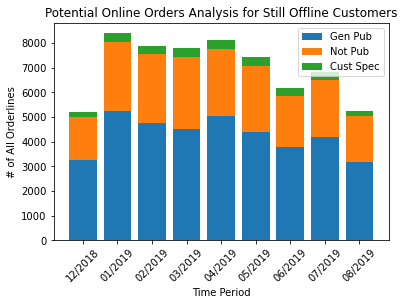

In [26]:
still_offline_offline_df = still_offline_customer_orders_df[still_offline_customer_orders_df['PurchaseOrderTypeDescription'] == 'Offline']
still_offline_genpub_df = still_offline_offline_df[still_offline_offline_df['MaterialGroup2Description'] == 'General published'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
still_offline_notpub_df = still_offline_offline_df[still_offline_offline_df['MaterialGroup2Description'] == 'Do not publish'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
still_offline_custspec_df = still_offline_offline_df[still_offline_offline_df['MaterialGroup2Description'] == 'Customer-specific published'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

print (still_offline_customer_orders_df.MaterialGroup2Description.value_counts())

list_of_date_bins_genpub = []
list_of_group_sizes_genpub = []
for name, group in still_offline_genpub_df:
    list_of_date_bins_genpub.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_genpub.append(group.shape[0])

list_of_date_bins_notpub = []
list_of_group_sizes_notpub = []
for name, group in still_offline_notpub_df:
    list_of_date_bins_notpub.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_notpub.append(group.shape[0])
    
list_of_date_bins_custspec = []
list_of_group_sizes_custspec = []
for name, group in still_offline_custspec_df:
    list_of_date_bins_custspec.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_custspec.append(group.shape[0])
    
genpub_plus_notpub = [x + y for x, y in zip(list_of_group_sizes_genpub, list_of_group_sizes_notpub)]

print (list_of_group_sizes_genpub)
print (list_of_group_sizes_notpub)
print (list_of_group_sizes_custspec)

list_of_group_sizes_genpub_normed = [x*100 / (float(len(df_orders))) for x in list_of_group_sizes_genpub]
list_of_group_sizes_notpub_normed = [x*100 / float(len(df_orders)) for x in list_of_group_sizes_notpub]
list_of_group_sizes_custspec_normed = [x*100 / float(len(df_orders)) for x in list_of_group_sizes_custspec]

genpub_plus_notpub_normed = [x + y for x, y in zip(list_of_group_sizes_genpub_normed, list_of_group_sizes_notpub_normed)]

plt.bar(list_of_date_bins_genpub, list_of_group_sizes_genpub, label = 'Gen Pub')
plt.bar(list_of_date_bins_notpub, list_of_group_sizes_notpub, bottom = list_of_group_sizes_genpub, label = 'Not Pub')
plt.bar(list_of_date_bins_custspec, list_of_group_sizes_custspec, bottom = genpub_plus_notpub, label = 'Cust Spec')

plt.legend()
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.ylabel("# of All Orderlines")
plt.title("Potential Online Orders Analysis for Still Offline Customers")

## Still Online customers

General published                        9918
Do not publish                           3910
Customer-specific published              1579
Negative PIM gen.publ., BU correction      13
Drop general publ. query, check PIM         8
General publ. query, check PIM              2
Name: MaterialGroup2Description, dtype: int64


Text(0.5, 1.0, 'Potential Online Orders Analysis for Still Online Customers')

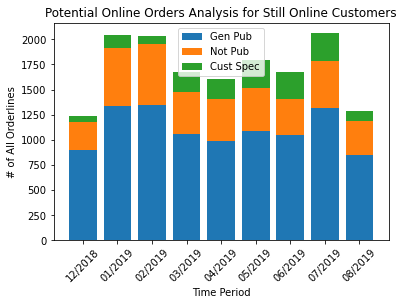

In [27]:
still_online_offline_df = still_online_customer_orders_df[still_online_customer_orders_df['PurchaseOrderTypeDescription'] == 'Offline']
still_online_genpub_df = still_online_offline_df[still_online_offline_df['MaterialGroup2Description'] == 'General published'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
still_online_notpub_df = still_online_offline_df[still_online_offline_df['MaterialGroup2Description'] == 'Do not publish'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
still_online_custspec_df = still_online_offline_df[still_online_offline_df['MaterialGroup2Description'] == 'Customer-specific published'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

print (still_online_offline_df.MaterialGroup2Description.value_counts())


list_of_date_bins_genpub = []
list_of_group_sizes_genpub = []
for name, group in still_online_genpub_df:
    list_of_date_bins_genpub.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_genpub.append(group.shape[0])

list_of_date_bins_notpub = []
list_of_group_sizes_notpub = []
for name, group in still_online_notpub_df:
    list_of_date_bins_notpub.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_notpub.append(group.shape[0])
    
list_of_date_bins_custspec = []
list_of_group_sizes_custspec = []
for name, group in still_online_custspec_df:
    list_of_date_bins_custspec.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_custspec.append(group.shape[0])
    
genpub_plus_notpub = [x + y for x, y in zip(list_of_group_sizes_genpub, list_of_group_sizes_notpub)]

list_of_group_sizes_genpub_normed = [x*100 / (float(len(df_orders))) for x in list_of_group_sizes_genpub]
list_of_group_sizes_notpub_normed = [x*100 / float(len(df_orders)) for x in list_of_group_sizes_notpub]
list_of_group_sizes_custspec_normed = [x*100 / float(len(df_orders)) for x in list_of_group_sizes_custspec]

genpub_plus_notpub_normed = [x + y for x, y in zip(list_of_group_sizes_genpub_normed, list_of_group_sizes_notpub_normed)]

plt.bar(list_of_date_bins_genpub, list_of_group_sizes_genpub, label = 'Gen Pub')
plt.bar(list_of_date_bins_notpub, list_of_group_sizes_notpub, bottom = list_of_group_sizes_genpub, label = 'Not Pub')
plt.bar(list_of_date_bins_custspec, list_of_group_sizes_custspec, bottom = genpub_plus_notpub, label = 'Cust Spec')

plt.legend()
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.ylabel("# of All Orderlines")
plt.title("Potential Online Orders Analysis for Still Online Customers")


# Which industries are placing the most offline orders, which could have been placed online?  

Text(0.5, 1.0, 'General Published and Offline Orderlines for Converted Customers')

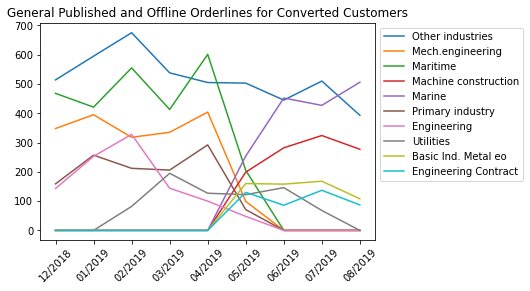

In [28]:
converted_customer_orders_df = converted_customer_orders_df[converted_customer_orders_df['MaterialGroup2Description'] == 'General published']
converted_customer_orders_df_grouped = converted_customer_orders_df[converted_customer_orders_df['PurchaseOrderTypeDescription'] == 'Offline'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_industries = converted_customer_orders_df.IndustryCode2Description.value_counts().nlargest(10).index.tolist()
list_of_date_bins = []

converted_customer_orders_df_grouped_all_channels = converted_customer_orders_df.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

for name, group in converted_customer_orders_df_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    
df = pd.DataFrame(0, columns = list_of_industries, index = list_of_date_bins) 

for name, group in converted_customer_orders_df_grouped:    
    months_industry_df = group.groupby(["IndustryCode2Description"]).count()["CustomerId"].reset_index(name='count').nlargest(10, 'count')
    for i in list_of_industries:
        list_of_active_industries_in_month = months_industry_df['IndustryCode2Description'].unique()
        if i in list_of_active_industries_in_month:  
            df.loc[name.date().strftime('%m/%Y')].at[i] = months_industry_df.loc[months_industry_df['IndustryCode2Description'] == i, 'count'].iloc[0]     
df.plot()
plt.xticks(rotation = 45)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
df.head(n=10)
plt.title("General Published and Offline Orderlines for Converted Customers")

# Bonus: D+E Customers ordering via ePDF or EDI

These customers shouldn't be using ePDF and EDI, who's using these methods? 

In [29]:
filter_list = ['ePDF', 'EDI']
EPDF_and_EDI_customers_df = converted_customer_orders_df[converted_customer_orders_df.PurchaseOrderTypeDescription.isin(filter_list)]
print (f"Number of ePDF and EDI orders from D + E customers = {len(EPDF_and_EDI_customers_df)}")
Customer_names = EPDF_and_EDI_customers_df.CustomerName.unique()
df_cust_names = pd.DataFrame(list(Customer_names)) 


Number of ePDF and EDI orders from D + E customers = 1506
